The paper is from, 
https://www.hanspub.org/journal/paperinformation?paperid=28497

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import skew, kurtosis, shapiro


### Basic data cleaning

In [ ]:
file_path = r"C:\Users\DELL\Desktop\Interview\Assignment_3\raw_data"
output_path = r"C:\Users\DELL\Desktop\Interview\Assignment_3\output"


In [ ]:

# Read the file
index_df = pd.read_csv(rf"{file_path}/daily_market_index.csv")
# Rename the columns
index_df.columns = ["index_code", "date", "closing_index"]
# Time formatting.
index_df["date"] = pd.to_datetime(index_df["date"]).dt.to_period(freq = "M")
# Only monthly closing index.
# keep = "last": among duplicates, keep the last occurrence (based on the row order)
index_df = index_df.drop_duplicates(subset=["date", "index_code"], keep = "last").reset_index(drop = True)

# Only CSI300 index.
# Converts all values in the "index_code" column to string type (as code in CSV file is treated as int)
index_df["index_code"] = index_df["index_code"].astype(str)
# Filters the df to only include the rows where index_code is "300".
index_df = index_df.loc[index_df["index_code"] == "300", :]  


### Problem 1 (a)

In [ ]:
# Manually calculate the monthly return.
index_df["return"] = index_df["closing_index"].pct_change()
index_df = index_df.loc[index_df["date"] > "2005-12", :]

In [ ]:
mean = index_df["return"].mean()
std = index_df["return"].std()
skewness = skew(index_df["return"])
kurtosis = kurtosis(index_df["return"])

# Create summary statistics dataframe.
summary = pd.DataFrame({"Mean": [mean], "Standard deviation": [std], "Skewness": [skewness], "Kurtosis": [kurtosis]})
summary = summary.round(4)
print(summary)
# idnex = False: row index of the DataFrame will not be saved to the CSV file.
summary.to_csv(rf"{output_path}/summary_statistics.csv", index = False)

     Mean  Standard deviation  Skewness  Kurtosis
0  0.0094              0.0818     0.009    1.3758


### Problem 1 (b)

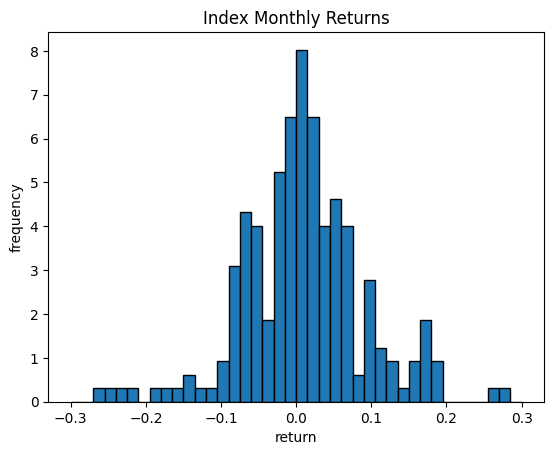

In [ ]:
# Plot a histogram for monthly returns, y-axis is density
plt.hist(index_df["return"], bins = 40, range=(-0.3, 0.3), density = True, edgecolor = "black")
plt.title("Index Monthly Returns")
plt.xlabel("return")
plt.ylabel("frequency")

# Save the histogram as pic
plt.savefig(rf"{output_path}/histogram_index_returns.png", dpi = 300)
plt.show()

In [ ]:
# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(index_df["return"])

# Print the test results
print(f"Shapiro-Wilk test statistic: {statistic}")
print(f"p-value: {p_value}")

# Form the dataframe of statistics
test_statistics = pd.DataFrame({"Shapiro-Wilk test statistic": [statistic], "p_value": [p_value]})
test_statistics = test_statistics.round(3)
test_statistics.to_csv(rf"{output_path}/test_statistics.csv", index = False)

Shapiro-Wilk test statistic: 0.9722275733947754
p-value: 0.0002926263550762087


### Problem 2

### Basic data cleaning

In [55]:
# Concatanate two stock dataframes.
stock_df_1 = pd.read_csv(rf"{file_path}/weekly_stock_trading_p1.csv")
stock_df_2 = pd.read_csv(rf"{file_path}/weekly_stock_trading_p2.csv")

# axis = 0 (default): vertical concatanation.
# axis = 1: horizontal concatanation.
stock_df = pd.concat([stock_df_1, stock_df_2], axis = 0)

# Rename the columns.
stock_df.columns = ["stock_code", "week", "return_i", "market_type"]

# Only A shares.
stock_df = stock_df.loc[(stock_df["market_type"] == 1) | (stock_df["market_type"] == 4) | (stock_df["market_type"] == 64), :]

# Drop unnecessary column.
stock_df.drop(columns=["market_type"], inplace = True)

# Calculate the weekly market return as the mean value of weekly returns of all main board stocks.
market_df = stock_df.groupby("week")["return_i"].mean()
# Since market_df is a pandas series, we want it to be a dataframe.
# By to_frame(). we convert it to a df.
# reset_index(): move the index "week" to a normal column.
market_df = market_df.to_frame().reset_index()
market_df.columns = ["week", "return_market"]

In [56]:
risk_free_df = pd.read_csv(rf"{file_path}/daily_risk_free_return.csv")
risk_free_df = risk_free_df.drop(columns = ["Nrr1_en"])
risk_free_df.columns = ["week", "risk_free"]

risk_free_df["week"] = pd.to_datetime(risk_free_df["week"]).dt.strftime("%Y-%W").astype("str")

risk_free_df[["year", "week_num"]] = risk_free_df["week"].str.split('-', expand = True)

risk_free_df["week_num"] = (risk_free_df["week_num"].astype("int") + 1).astype("str").str.zfill(2)

risk_free_df["week"] = risk_free_df["year"] + '-' + risk_free_df['week_num']
risk_free_df = risk_free_df.drop(columns=["year", "week_num"])
risk_free_df

,week,risk_free
0,2018-02,0.0286
1,2018-02,0.0286
2,2018-02,0.0286
3,2018-02,0.0286
4,2018-02,0.0286
...,...,...
2186,2023-53,0.0286
2187,2023-53,0.0286
2188,2023-53,0.0286
2189,2023-53,0.0286


In [57]:
return_df = pd.merge(stock_df, market_df, on = "week", how = "left")
return_df.dropna(inplace = True)
return_df["week"] = return_df["week"].astype("str")
return_df

,stock_code,week,return_i,return_market
0,1,2015-02,-0.047980,0.018127
1,1,2015-03,0.019231,0.015072
2,1,2015-04,-0.063110,0.033266
3,1,2015-05,-0.032639,0.007333
4,1,2015-06,-0.030151,-0.018334
...,...,...,...,...
1271062,873833,2023-48,-0.056550,-0.003702
1271063,873833,2023-49,0.086495,-0.009678
1271064,873833,2023-50,0.065642,0.012560
1271065,873833,2023-51,-0.104194,-0.028596


### Regression Part

#### Part 1

In [58]:
results = pd.DataFrame()

# In term 1, we select the data from 2016 and 2017 to gain beta_i
stock_term_1 = return_df.loc[(return_df["week"].str.startswith("2016")) | (return_df["week"].str.startswith("2017")), :]

for stock in stock_term_1["stock_code"].unique():
    code_data = stock_term_1[stock_term_1["stock_code"] == stock]
    
    X = code_data["return_market"]
    X = sm.add_constant(X)
    y = code_data["return_i"]
    
    model = sm.OLS(y, X)
    regression_result = model.fit()
    
    try:
        alpha = regression_result.params["const"]
        beta_i = regression_result.params["return_market"]
        R_squared = regression_result.rsquared

        results = pd.concat([results, pd.DataFrame({"stock_code": [stock], "alpha": [alpha], "beta_i": [beta_i], "R_squared": [R_squared]})], ignore_index = True)
        
    except KeyError:
        pass

In [59]:
# By the values of βi, divide the stocks into 10 groups in the term 1.

# This step is to remove the stocks that were just issued.
results = results[results["R_squared"] != 1] 

results = results.sort_values(by = "beta_i")
results["group"] = pd.qcut(results["beta_i"], 10, labels = False)
results["group"] = (results["group"] + 1).astype("int")

return_df = pd.merge(return_df, results[["stock_code", "group"]], on = "stock_code", how = "left")

In [ ]:
portfolio_df = return_df.groupby(["week", "group"])["return_i"].mean()
portfolio_df = portfolio_df.to_frame().reset_index()
portfolio_df.columns = ["week", "group", "return_portfolio"]

portfolio_df = pd.merge(portfolio_df, risk_free_df, on = "week", how = "left")
portfolio_df = pd.merge(portfolio_df, market_df, on = "week", how = "left")
portfolio_df.dropna(inplace = True)

portfolio_df["excess_return"] = portfolio_df["return_portfolio"] - portfolio_df["risk_free"]
portfolio_df["risk_premium"] = portfolio_df["return_market"] - portfolio_df["risk_free"]
portfolio_df

,week,group,return_portfolio,risk_free,return_market,excess_return,risk_premium
1540,2018-02,1.0,0.007331,0.0286,-0.002028,-0.021269,-0.030628
1541,2018-02,1.0,0.007331,0.0286,-0.002028,-0.021269,-0.030628
1542,2018-02,1.0,0.007331,0.0286,-0.002028,-0.021269,-0.030628
1543,2018-02,1.0,0.007331,0.0286,-0.002028,-0.021269,-0.030628
1544,2018-02,1.0,0.007331,0.0286,-0.002028,-0.021269,-0.030628
...,...,...,...,...,...,...,...
22755,2023-52,10.0,0.023870,0.0286,0.029211,-0.004730,0.000611
22756,2023-52,10.0,0.023870,0.0286,0.029211,-0.004730,0.000611
22757,2023-52,10.0,0.023870,0.0286,0.029211,-0.004730,0.000611
22758,2023-52,10.0,0.023870,0.0286,0.029211,-0.004730,0.000611


#### Part 2

In [ ]:
results_2 = pd.DataFrame()

# In term 2, we use the data form 2018 and 2019 to gain beta_p.
regression_portfolio = portfolio_df.loc[(portfolio_df["week"].str.startswith("2018")) | (portfolio_df["week"].str.startswith("2019")), :]

for group in regression_portfolio["group"].unique():
    group_data = regression_portfolio[regression_portfolio["group"] == group]
    
    X = group_data["risk_premium"]
    X = sm.add_constant(X)
    y = group_data["excess_return"]
    
    model = sm.OLS(y, X)
    regression_result = model.fit()
    
    alpha = regression_result.params["const"]
    beta_p = regression_result.params["risk_premium"]

    alpha_t = regression_result.tvalues.iloc[0]
    beta_t = regression_result.tvalues.iloc[1]

    alpha_p = regression_result.pvalues.iloc[0]
    beta_p_p = regression_result.pvalues.iloc[1]
    
    R_squared = regression_result.rsquared
    

    results_2 = pd.concat([results_2, pd.DataFrame({"group": [group], 
                                                        "alpha": [alpha], "alpha_t": [alpha_t], "alpha_p": [alpha_p], 
                                                        "beta_p": [beta_p], "beta_t": [beta_t], "beta_p_p": [beta_p_p], 
                                                        "R_squared": [R_squared]})], ignore_index = True)



output_reg_result = results_2
# All data in output_reg_result is rounded to 4 decimal places
output_reg_result = output_reg_result.round(4)
output_reg_result.columns = ['Group', 'alpha_p', 'alpha t-value', 'alpha p-value', 'beta_p', 'beta t-value', 'beta p-value', 'R^2']
output_reg_result.to_csv(rf"{output_path}/results_2.csv", index = False)
output_reg_result

,Group,alpha_p,alpha t-value,alpha p-value,beta_p,beta t-value,beta p-value,R^2
0,1.0,-0.0064,-15.6429,0.0000,0.7645,85.6765,0.0,0.9123
1,2.0,-0.0042,-13.1679,0.0000,0.8608,122.7854,0.0,0.9553
2,3.0,-0.0025,-12.0486,0.0000,0.9234,202.5058,0.0,0.9831
3,4.0,-0.0015,-7.4888,0.0000,0.9711,220.2358,0.0,0.9857
4,5.0,-0.0004,-1.9017,0.0576,1.0053,227.8715,0.0,0.9866
5,6.0,0.0010,5.5236,0.0000,1.0614,265.8929,0.0,0.9901
6,7.0,0.0022,8.4086,0.0000,1.0911,188.3292,0.0,0.9805
7,8.0,0.0033,13.3445,0.0000,1.1117,207.8137,0.0,0.9839
8,9.0,0.0028,7.8495,0.0000,1.1126,143.7155,0.0,0.9669
9,10.0,0.0032,5.8341,0.0000,1.0727,90.3783,0.0,0.9204


#### Part 3

In [62]:
# In term 3, we select the data from 2020, 2021, and 2022 to test the CAPM.
regression_portfolio_2 = portfolio_df.loc[(portfolio_df["week"].str.startswith("2020")) | (portfolio_df['week'].str.startswith("2021")) | (portfolio_df['week'].str.startswith("2022")), :]
regression_portfolio_2 = regression_portfolio_2.groupby("group")["excess_return"].mean()
regression_portfolio_2 = regression_portfolio_2.to_frame().reset_index()

regression_portfolio_2 = pd.merge(regression_portfolio_2, results_2[["group", "beta_p"]], on = "group", how = "left")
regression_portfolio_2

,group,excess_return,beta_p
0,1.0,-0.026238,0.764524
1,2.0,-0.026593,0.860792
2,3.0,-0.026280,0.923446
3,4.0,-0.025825,0.971069
4,5.0,-0.025943,1.005341
5,6.0,-0.026179,1.061431
6,7.0,-0.025731,1.091098
7,8.0,-0.026105,1.111692
8,9.0,-0.026216,1.112631
9,10.0,-0.025963,1.072724


In [ ]:
results_3 = pd.DataFrame()

X = regression_portfolio_2["beta_p"]
X = sm.add_constant(X)
y = regression_portfolio_2["excess_return"]

model = sm.OLS(y, X)
results_3 = model.fit()
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     2.664
Date:                Tue, 03 Jun 2025   Prob (F-statistic):              0.141
Time:                        23:42:37   Log-Likelihood:                 70.652
No. Observations:                  10   AIC:                            -137.3
Df Residuals:                       8   BIC:                            -136.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0272      0.001    -41.256      0.0

d:\Quant\Codes\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [66]:

# Store intercept, beta, intercept t-value, beta t-value, R^2, F-statistic, P(F-statistic) in a dataframe
output_reg_result = pd.DataFrame({"gamma_0": [results_3.params["const"]], "gamma_1": [results_3.params["beta_p"]], 
                                  "gamma_{0}  t-value": [results_3.tvalues[0]], "gamma_{1}  t-value": [results_3.tvalues[1]], 
                                  "R^2": [results_3.rsquared], "F-statistic": [results_3.fvalue], "P": [results_3.f_pvalue]})
output_reg_result = output_reg_result.round(4)
output_reg_result.to_csv(rf"{output_path}/output_T3.csv", index = False)

C:\Users\DELL\AppData\Local\Temp\ipykernel_10448\459184127.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "gamma_{0}  t-value": [results_3.tvalues[0]], "gamma_{1}  t-value": [results_3.tvalues[1]],


#### Show the graph

Text(0, 0.5, 'Excess Return')

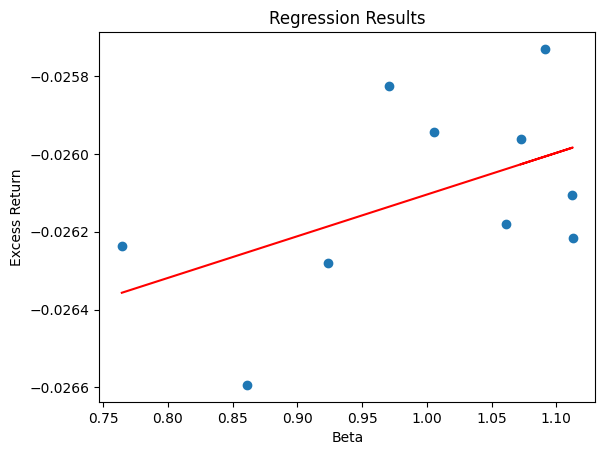

In [ ]:
# Plot the regression results.
plt.scatter(regression_portfolio_2["beta_p"], regression_portfolio_2["excess_return"])
# Independent variable: beta_p
# Dependent variable: alpha + coefficient of beta_p (results_3.params["beta_p"]) * beta_p (regression_portfolio_2["beta_p"])
plt.plot(regression_portfolio_2["beta_p"], results_3.params["const"] + results_3.params["beta_p"] * regression_portfolio_2["beta_p"], color = "red")

plt.title("Regression Results")
plt.xlabel("Beta")
plt.ylabel("Excess Return")